# Data

Let's have a look at the data first

In [1]:
import os
from pathlib import Path

input_data_path = Path(os.environ.get('INPUT_DATA_PATH', '.'))
output_data_path = Path(os.environ.get('OUTPUT_DATA_PATH', '.'))

train_file = str(input_data_path / "data_train.npz")
test_file = str(input_data_path / "data_test.npz")
prediction_file = str(output_data_path / "data_test_prediction.npz")


if not (os.path.isfile(train_file) and
        os.path.isfile(test_file)):
    if not os.path.isfile("input_public_data.zip"):
        !wget https://codalab.coresearch.club/my/datasets/download/37304c34-1d4a-4f43-bcb2-1fdeb37c5cba -O input_public_data.zip
    !unzip -n input_public_data.zip

In [2]:
import numpy as np

In [3]:
data_real = np.load(train_file, allow_pickle=True)

# This is the calorimeter response:
energy = data_real['EnergyDeposit']

# These are the quantities we want to predict
momentum = data_real['ParticleMomentum'][:,:2]
coordinate = data_real['ParticlePoint'][:,:2]

In [4]:
[ k for k in data_real.keys() ]

['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum']

In [5]:
print('energy.shape:', energy.shape)
print('momentum.shape:', momentum.shape)
print('coordinate.shape:', coordinate.shape)

energy.shape: (9916, 30, 30)
momentum.shape: (9916, 2)
coordinate.shape: (9916, 2)


So, we have images of 30x30 pixels and we want to predict 4 numbers for each of them: x, y, px and py.

Let's have a look at some of the images

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Beware that imshow normalizes each patches independently (set vmin, vmax to global minimum and maximum to avoid it)

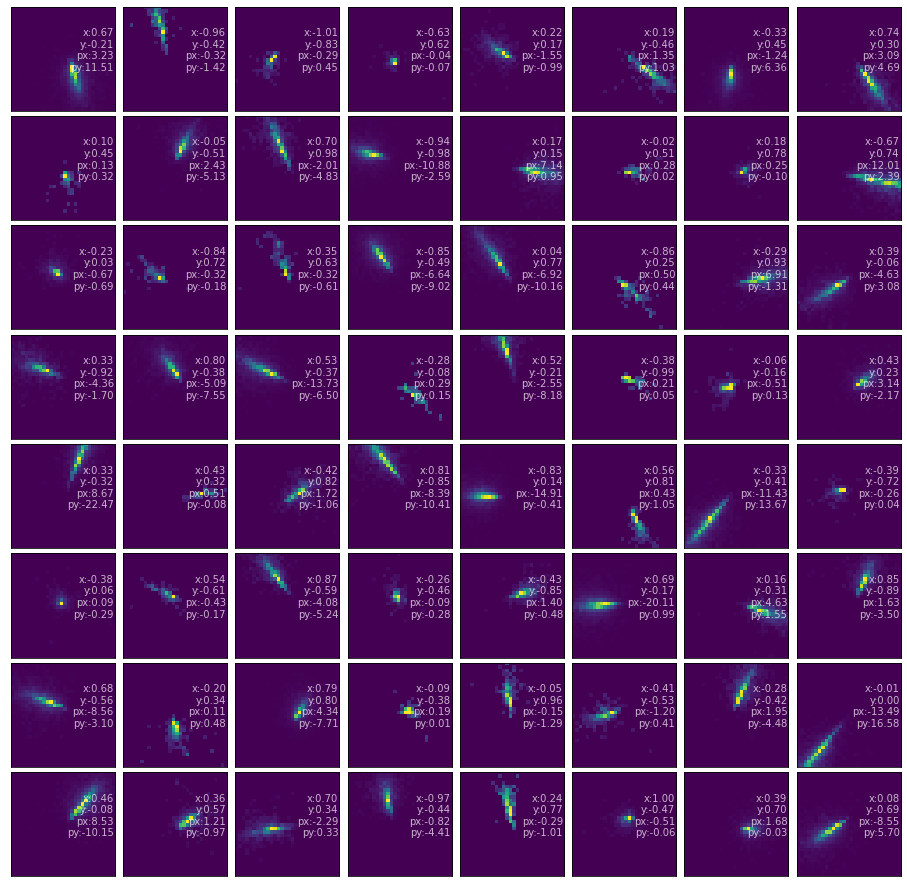

In [7]:
nrows = 8
ncols = 8
fig, ax = plt.subplots(figsize=(16, 16))
gs = GridSpec(nrows, ncols, wspace=0.05, hspace=0.05)

rng = np.random.RandomState(42)
samples = rng.choice(len(energy), nrows * ncols)
for i, s in enumerate(samples):
    ax = plt.subplot(gs[i])
    ax.imshow(energy[s])
    ax.text(0.99, 0.8,
            f'x:{coordinate[s][0]:.2f}\ny:{coordinate[s][1]:.2f}\n'+
            f'px:{momentum[s][0]:.2f}\npy:{momentum[s][1]:.2f}',
            color="white", alpha=0.7,
            horizontalalignment="right", verticalalignment="top",
            transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

Let's try to approach this from a purely blackbox point of view.

Is there any space for some data augmentation? looks like reflections of the images correspond to a change of sign in momentum, but that doesn't seem true for the coordinate.

Maybe we could train a GAN to produce more samples? seems silly, given the samples already come from a GAN model we should generate more there.

Any physical insight that may help here?

It's also worth knowing how the targets are distributed:

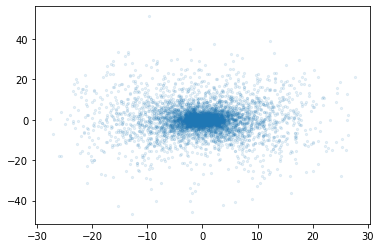

In [8]:
plt.scatter(*momentum.T, s=5, alpha=0.1);

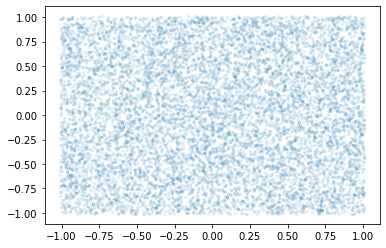

In [9]:
plt.scatter(*coordinate.T, s=5, alpha=0.1);

Naive approach: can we predict the coordinates from the center of mass position of the calorimeter response?

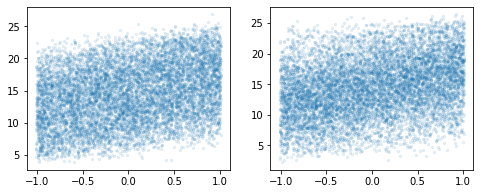

In [10]:
energy_density = energy / energy.sum(axis=(1, 2), keepdims=True)

cell_coords = np.stack([*np.meshgrid(
    np.arange(energy.shape[1]),
    np.arange(energy.shape[2])
)], axis=-1)[None,...]

center_of_mass = (energy_density[...,None] * cell_coords).sum(axis=(1, 2))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(coordinate[:,0], center_of_mass[:,0], s=5, alpha=0.1)
plt.subplot(122)
plt.scatter(coordinate[:,1], center_of_mass[:,1], s=5, alpha=0.1);

Looks like the correlation isn't too strong. Maybe higher moments would give us a better picture, but we'll leave such experiments to you.

What about momentum? it looks more correlated

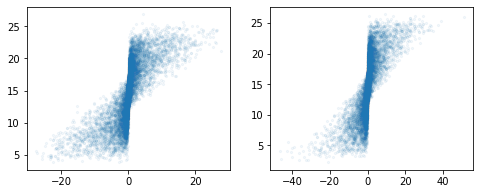

In [11]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(momentum[:,0], center_of_mass[:,0], s=5, alpha=0.05)
plt.subplot(122)
plt.scatter(momentum[:,1], center_of_mass[:,1], s=5, alpha=0.05);

# Example solution

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim

from IPython.display import clear_output
# from tqdm.notebook import tqdm
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [13]:
X = energy[:,None,...] # adding Channels dimension
Y = np.concatenate([coordinate, momentum], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(8428, 1, 30, 30) (8428, 4) (1488, 1, 30, 30) (1488, 4)


In [14]:
def make_torch_dataset(X, Y, batch_size, shuffle=True):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    ds = utils.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        ds, batch_size=batch_size,
        pin_memory=True, shuffle=shuffle
    )

BATCH_SIZE = 256

ds_train = make_torch_dataset(X_train, Y_train, BATCH_SIZE)
ds_val = make_torch_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# derived from https://github.com/KellerJordan/ResNet-PyTorch-CIFAR10/blob/master/model.py

class ResNet(nn.Module):
    
    def __init__(self, n=7, res_option='A', use_dropout=False):
        super(ResNet, self).__init__()
        self.res_option = res_option
        self.use_dropout = use_dropout
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.layers1 = self._make_layer(n, 16, 16, 1)
        self.layers2 = self._make_layer(n, 32, 16, 2)
        self.layers3 = self._make_layer(n, 64, 32, 2)
        self.avgpool = nn.AvgPool2d(2)
        self.do11 = nn.Dropout()
        self.fc11 = nn.Linear(1024, 1024)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc12 = nn.Linear(1024, 2)
        self.do21 = nn.Dropout()
        self.fc21 = nn.Linear(1024, 1024)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc22 = nn.Linear(1024, 2)
    
    def _make_layer(self, layer_count, channels, channels_in, stride):
        return nn.Sequential(
            ResBlock(channels, channels_in, stride, res_option=self.res_option, use_dropout=self.use_dropout),
            *[ResBlock(channels) for _ in range(layer_count-1)])
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.layers1(out)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out1 = self.fc11(out)
        out1 = self.do11(out)
        out1 = self.relu2(out1)
        out1 = self.fc12(out1)
        out2 = self.fc21(out)
        out2 = self.do21(out)
        out2 = self.relu3(out2)
        out2 = self.fc22(out2)
        return torch.cat([out1, out2], axis=1)

class ResBlock(nn.Module):
    
    def __init__(self, num_filters, channels_in=None, stride=1, res_option='A', use_dropout=False):
        super(ResBlock, self).__init__()

        if not channels_in or channels_in == num_filters:
            channels_in = num_filters
            self.projection = None
        else:
            if res_option == 'A':
                self.projection = IdentityPadding(num_filters, channels_in, stride)
            elif res_option == 'B':
                self.projection = ConvProjection(num_filters, channels_in, stride)
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(channels_in, num_filters, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
        if self.use_dropout:
            self.dropout = nn.Dropout2d(0.1)
        self.relu2 = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_dropout:
            out = self.dropout(out)
        if self.projection:
            residual = self.projection(x)
        out += residual
        out = self.relu2(out)
        return out


# various projection options to change number of filters in residual connection
# option A from paper
class IdentityPadding(nn.Module):
    def __init__(self, num_filters, channels_in, stride):
        super(IdentityPadding, self).__init__()
        # with kernel_size=1, max pooling is equivalent to identity mapping with stride
        self.identity = nn.MaxPool2d(1, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out

# option B from paper
class ConvProjection(nn.Module):

    def __init__(self, num_filters, channels_in, stride):
        super(ConvProjection, self).__init__()
        self.conv = nn.Conv2d(channels_in, num_filters, kernel_size=1, stride=stride)
    
    def forward(self, x):
        out = self.conv(x)
        return out

In [16]:
device = torch.device('cuda:0')
regressor = ResNet(3, "A", use_dropout=True).to(device)

In [17]:
# from torchsummary import summary
# summary(regressor, X.shape[1:])

In [18]:
def metric_relative_mse(y_true, y_pred):
    return (
        (y_true - y_pred).pow(2).mean(dim=0) / y_true.pow(2).mean(dim=0)
    )

def metric_relative_mse_total(y_true, y_pred):
    return metric_relative_mse(y_true, y_pred).sum()

In [19]:
opt = optim.Adam(regressor.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss().to(device)

epochs = 600
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[200, 300, 400, 500], gamma=0.5)

In [20]:
losses_train = []
losses_val = []
metrics_train = []
metrics_val = []
per_component_metrics_train = []
per_component_metrics_val = []

def run_training(epochs=5, plot_every=1):
    t = tqdm(range(epochs))
    for epoch in t:
        regressor.train()
        for batch_X, batch_Y in ds_train:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
            loss = loss_fn(batch_Y, pred)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses_train.append(loss.item())
            metrics_train.append(metric_relative_mse_total(batch_Y, pred).item())
            per_component_metrics_train.append(metric_relative_mse(batch_Y, pred).detach().cpu().numpy())

        avg_loss, avg_metrics, avg_per_component_metrics = [], [], []
        
        regressor.eval()
        with torch.no_grad():
            for batch_X, batch_Y in ds_val:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

                pred = regressor(batch_X)
                loss = loss_fn(pred, batch_Y)

                avg_loss.append(loss.item())
                avg_metrics.append(metric_relative_mse_total(batch_Y, pred).item())
                avg_per_component_metrics.append(metric_relative_mse(batch_Y, pred).detach().cpu().numpy())  

        losses_val.append(np.mean(avg_loss))
        metrics_val.append(np.mean(avg_metrics))
        per_component_metrics_val.append(np.mean(avg_per_component_metrics, axis=0))
        
        scheduler.step()
        t.set_description(f'loss: {np.mean(avg_loss):.2}, metrics: {np.mean(avg_metrics):.2}')
        t.refresh()
        
        if ((epoch % plot_every) != 0): continue

        clear_output(wait=True)        
        fig, axs = plt.subplots(1, 3, figsize=(18, 4.5))

        ax = axs[0]
        ax.set_title("Loss")
        ax.plot(losses_train, label='train')
        ax.plot(np.linspace(0, len(losses_train), len(losses_val), endpoint=False),
                losses_val, label='val')
        ax.set_ylim(0, 5)
        ax.legend()

        ax = axs[1]
        ax.set_title("Metric (per component)")
        components = ["x", "y", "px", "py"]
        ms_train = np.array(per_component_metrics_train).T
        ms_val = np.array(per_component_metrics_val).T
        for i, (m_train, m_val) in enumerate(zip(ms_train, ms_val)):
            ax.plot(m_train, label=f'train ({components[i]})', c=f'C{i}')
            ax.plot(np.linspace(0, len(m_train), len(m_val), endpoint=False),
                    m_val, '--', label=f'val ({components[i]})', c=f'C{i}')
        ax.legend()


        ax = axs[2]
        ax.set_title("Metric (total)")
        ax.plot(metrics_train, label='train')
        ax.plot(np.linspace(0, len(metrics_train), len(metrics_val), endpoint=False),
                metrics_val, label='val')
        ax.set_ylim(0, 5)
        ax.legend()
        plt.show()

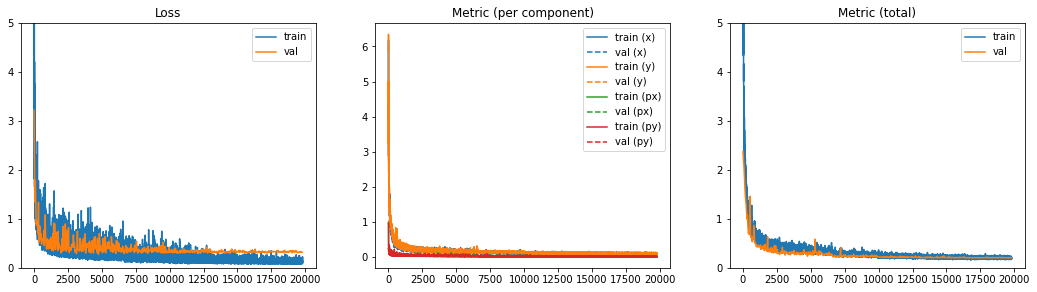

loss: 0.32, metrics: 0.2: 100%|██████████| 600/600 [20:01<00:00,  2.00s/it]


In [21]:
run_training(epochs)

In [22]:
print("mean val metrics over last 10 epochs: {:.2f}".format(np.mean(metrics_val[-10:])))

mean val metrics over last 10 epochs: 0.20


In [23]:
data_test = np.load(test_file, allow_pickle=True)
X_test = data_test['EnergyDeposit'][:,None,...]

In [24]:
regressor.eval()
with torch.no_grad():
    prediction_test = regressor(torch.tensor(X_test, device=device).float()).cpu()

In [25]:
coordinate_test, momentum_test = (
    prediction_test.detach().numpy()[:, :2],
    prediction_test.detach().numpy()[:, 2:],
)

In [26]:
np.savez_compressed(prediction_file,
                    ParticlePoint=coordinate_test,
                    ParticleMomentum=momentum_test)